<a href="https://colab.research.google.com/github/Dansoeun/AICOSS/blob/ChatBot/Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from sklearn.metrics import classification_report
import urllib.request

urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_text.npy", filename="train_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_text.npy", filename="test_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_label.npy", filename="train_label.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_label.npy", filename="test_label.npy")

('test_label.npy', <http.client.HTTPMessage at 0x7de8b109c760>)

# Data Preprocessing

In [ ]:
!ls

drive  sample_data  test_label.npy  test_text.npy  train_label.npy  train_text.npy


In [ ]:
old = np.load
np.load = lambda *a, **k: old(*a, allow_pickle=True, **k)

In [ ]:
import numpy as np

intent_train = np.load(open('train_text.npy', 'rb')).tolist()
label_train = np.load(open('train_label.npy', 'rb')).tolist()

knowledge_train_path = '/content/drive/MyDrive/AICOSS/일반상식'

try:
    with open(knowledge_train_path, 'r', encoding='utf-8') as file:
        knowledge_train = file.readlines()
except Exception as e:
    print(f"파일을 불러오는 중 문제가 발생했습니다: {e}")

intent_test = np.load(open('test_text.npy', 'rb')).tolist()
label_test = np.load(open('test_label.npy', 'rb')).tolist()

In [ ]:
print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))
print('일반상식 문장의 수 :', len(knowledge_train))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600
일반상식 문장의 수 : 68539


<Axes: >

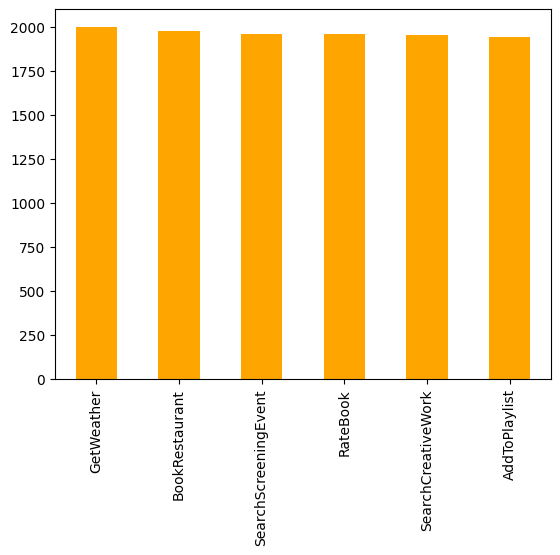

In [ ]:
temp = pd.Series(label_train)
temp.value_counts().plot(kind = 'bar',color='orange')

In [ ]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

LabelEncoder()

In [ ]:
label_train = idx_encode.transform(label_train)
label_test = idx_encode.transform(label_test)

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)

{'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5]

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


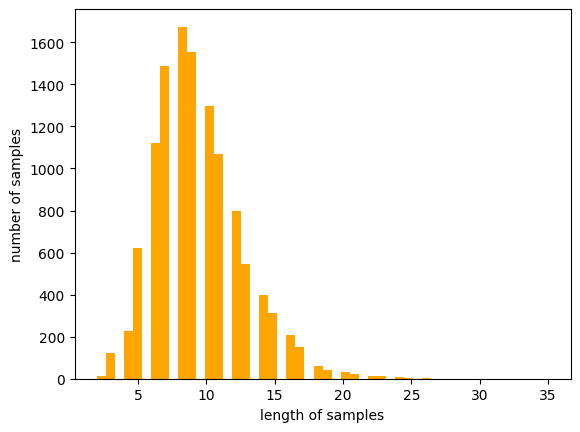

In [ ]:
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=50, color='orange')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len = 35
intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))
print('전체 데이터의 크기(shape):', intent_train.shape)
print('레이블 데이터의 크기(shape):', label_train.shape)


전체 데이터의 크기(shape): (11784, 35)
레이블 데이터의 크기(shape): (11784, 6)


In [ ]:
print(intent_train[0])
print(label_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   11  191
   61    4    1 4013 1141 1572   15]
[1. 0. 0. 0. 0. 0.]


In [ ]:
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)
print(indices)

[ 7066  9252 11525 ...  8295   325 10494]


In [ ]:
intent_train = intent_train[indices]
label_train = label_train[indices]

In [ ]:
n_of_val = int(0.1 * intent_train.shape[0])
print(n_of_val)

1178


In [ ]:
X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]
X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
X_test = intent_test
y_test = label_test
print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 개수(shape):', y_train.shape)
print('검증 데이터 레이블의 개수(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 개수(shape): (10606, 6)
검증 데이터 레이블의 개수(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-09-03 08:50:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-09-03 08:50:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-09-03 08:50:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
print(embedding_dict['playlist'])
print(len(embedding_dict['playlist']))

[-0.6528   -0.087126  0.069655 -0.5048    0.79019   0.65051   0.37976
  0.20751   0.10412   0.95853   0.32161   0.36098  -0.21461  -0.59657
  0.362    -0.3951   -0.58838   0.324     1.0287    0.4569   -0.24372
 -0.26496   0.1975   -0.78302   0.17163  -0.076737  0.83705   0.58432
  0.71843   0.57522   0.11688   0.011023 -0.53676   0.73441   0.09844
  0.8927   -0.211     0.015395 -0.2928   -1.3875    1.0756    0.13387
  0.20341   0.86427  -0.096482 -0.06536  -0.52669  -0.36076   0.76218
  0.3854   -0.39054   0.014445  0.20772   0.41165  -0.16024  -0.66007
  0.13666  -0.34246   0.4382    0.49848   0.31481  -0.13102  -0.17373
  0.061581  1.1336   -0.25673  -0.20472  -0.72834   0.38054  -0.35237
  0.033096  0.43066  -0.36101  -0.096088 -0.15556  -0.028297  0.32882
  0.019752  0.5847   -0.12215  -0.53096  -0.53096   0.25334  -0.13078
 -0.058533  0.40602  -0.23493   0.048578 -0.34938   1.0172   -0.44
  1.2431   -0.32026  -0.22517  -0.079004 -0.3919    0.18961  -0.42287
 -0.028161  0.92989 ]
1

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [ ]:
np.shape(embedding_matrix)

(9870, 100)

In [ ]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

In [ ]:
filter_sizes = [2,3,5]
num_filters = 512
drop = 0.5

In [ ]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for sz in filter_sizes:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(drop)(z)
model_output = Dense(len(label_idx), activation='softmax')(z)

model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 100)        │        987,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 34, 512)        │        102,912 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 33, 512)        │        154,112 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 31, 512)        │        256,512 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 512)            │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 512)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 512)            │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 512)            │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 512)            │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 512)            │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1536)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0],       │
│                           │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1536)           │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 6)              │          9,222 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,509,758 (5.76 MB)

 Trainable params: 522,758 (1.99 MB)

 Non-trainable params: 987,000 (3.77 MB)

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=50,
          validation_data = (X_val, y_val))

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - acc: 0.8605 - loss: 0.4221 - val_acc: 0.9771 - val_loss: 0.0686
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 160ms/step - acc: 0.9854 - loss: 0.0562 - val_acc: 0.9830 - val_loss: 0.0519
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - acc: 0.9942 - loss: 0.0254 - val_acc: 0.9839 - val_loss: 0.0505
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 46s 167ms/step - acc: 0.9939 - loss: 0.0204 - val_acc: 0.9847 - val_loss: 0.0507
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - acc: 0.9978 - loss: 0.0109 - val_acc: 0.9864 - val_loss: 0.0555
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 44s 168ms/step - acc: 0.9985 - loss: 0.0087 - val_acc: 0.9830 - val_loss: 0.0580
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 38s 148ms/step - acc: 0.9982 - loss: 0.0076 - val_acc: 0.9856 - val_loss: 0.0517
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 44s 167ms/step - acc: 0.9991 - loss: 0.0048 - val_acc: 0.9839 - val_loss: 0.0599
Epoch 9/50
166/166 ━━━━━━━━━━━━━

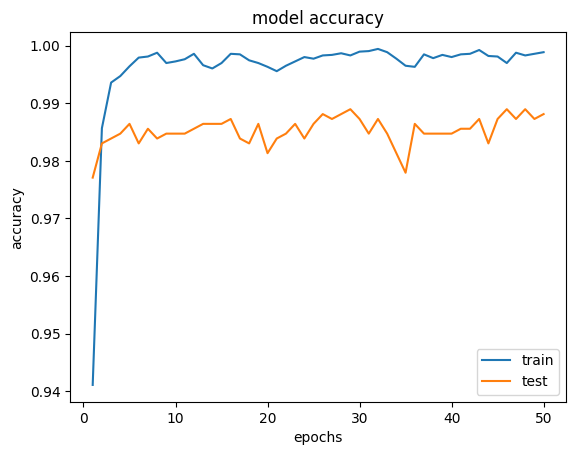

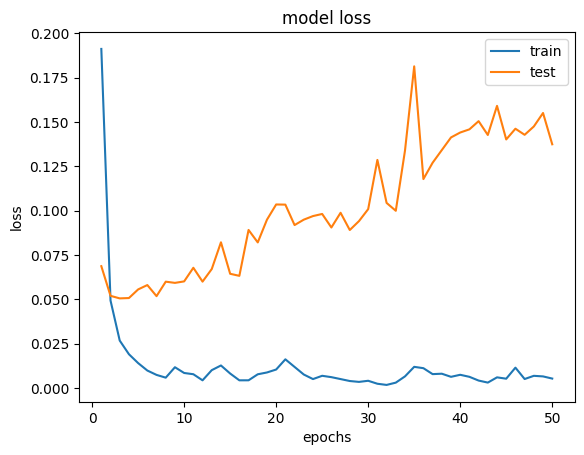

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [ ]:
y_predicted = idx_encode.inverse_transform(y_predicted)
y_test = idx_encode.inverse_transform(y_test)

In [ ]:
print('accuracy: ', sum(y_predicted == y_test) / len(y_test))
print("Precision, Recall and F1-Score:\n\n", classification_report(y_test, y_predicted))

accuracy:  0.985
Precision, Recall and F1-Score:

                       precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       0.99      1.00      1.00       100
          GetWeather       0.98      0.98      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.95      1.00      0.98       100
SearchScreeningEvent       0.99      0.93      0.96       100

            accuracy                           0.98       600
           macro avg       0.99      0.98      0.98       600
        weighted avg       0.99      0.98      0.98       600



# Text Preprocessing

In [ ]:
import os
import json
import pandas as pd

In [ ]:
def counting(path):
    cnt = 0
    data_dir = path

    for path in os.listdir(data_dir):
        if os.path.isfile(os.path.join(data_dir, path)):
            cnt += 1

    print(f'데이터 개수 = {cnt}')
    return cnt

In [ ]:
target_path = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv", encoding = "UTF-8")

In [ ]:
target_path

,Question,Answer
0,"치대 학생인데, 장학금을 받고싶어.",https://dent.knu.ac.kr/
1,의학과 교육과정을 알려줘,https://med.knu.ac.kr/pages/sub.htm?nav_code=k...
2,컴학 공지사항 알려줘,https://cse.knu.ac.kr/bbs/board.php?bo_table=s...
3,AIcoss 학생인데 gpu 서버 사용하고 싶어,https://aicoss.knu.ac.kr/gpu/list.do
4,인컴 교육과정 알려줘,https://cse.knu.ac.kr/sub3_3_b.php
...,...,...
190,봉사활동을 가고 싶은데 어캐해야할까,https://volunteer.knu.ac.kr/
191,수강 신청 하고 싶어,https://sugang.knu.ac.kr/login.knu
192,비교과 사이트가 궁금해,https://knucube.knu.ac.kr/knucube_index.jsp
193,예대에 대해 알고 싶어,https://mvarts.knu.ac.kr/


In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 23.3 MB/s eta 0:00:00


### 텍스트 전처리

In [ ]:
from konlpy.tag import Komoran

class Preprocess:
    def __init__(self, userdic=None):
        self.komoran = Komoran(userdic=userdic)

        self.exclusion_tags = [
            'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            'JX', 'JC',
            'SF', 'SP', 'SS', 'SE', 'SO',
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            'XSN', 'XSV', 'XSA'
        ]

    # pos 메서드 정의
    def pos(self, sentence):
        return self.komoran.pos(sentence)

    # get_keywords 메서드 정의
    def get_keywords(self, pos, without_tag=False):
        word_list = []
        for p in pos:
            if p[1] not in self.exclusion_tags:
                word_list.append(p if not without_tag else p[0])
        return word_list

# 코드 실행
sent = "컴학 공지사항을 알려줘"

p = Preprocess(userdic="/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv.tsv")

# 형태소 분석 실행
pos = p.pos(sent)

# 태그 포함 키워드 추출
ret = p.get_keywords(pos, without_tag=False)
print(ret)

# 태그 제외 키워드 추출
ret = p.get_keywords(pos, without_tag=True)
print(ret)


[('컴', 'NNG'), ('학', 'NNG'), ('공지', 'NNP'), ('사항', 'NNG'), ('알리', 'VV'), ('주', 'VX')]
['컴', '학', '공지', '사항', '알리', '주']


### 단어 사전 구축

In [ ]:
import pandas as pd

# CSV 파일을 불러오고 첫 몇 줄과 열 이름을 확인합니다.
topic = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv")

# 열 이름 출력
print(topic.columns)

Index(['Question', 'Answer'], dtype='object')


In [ ]:
import pandas as pd
from konlpy.tag import Komoran
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

topic = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv")

topic.dropna(inplace=True)

text = list(topic['Question'])

corpus_data = text

p = Preprocess()
dict = []
for c in corpus_data:
  pos = p.pos(c)
  for k in pos:
    dict.append(k[0])

tokenizer = Tokenizer(oov_token='OOV', num_words=100000)
tokenizer.fit_on_texts(dict)
word_index = tokenizer.word_index
print(f"사전에 포함된 단어 수: {len(word_index)}")

with open("chatbot_dict.bin", "wb") as f:
    pickle.dump(word_index, f)

사전에 포함된 단어 수: 439


In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

f = open("/content/chatbot_dict.bin", "rb")
word_index = pickle.load(f)
f.close()

sent = "안녕하세요. 테스트 코드입니다. 단어사전 만들기 성공!"

p = Preprocess(userdic="/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv.tsv")

pos = p.pos(sent)

keywords = p.get_keywords(pos, without_tag=True)
for word in keywords:
  try:
    print(word, word_index[word])
  except KeyError:
    print(word, word_index['OOV'])

안녕하세요 1
테스트 1
코드 1
이 11
단어 1
사전 1
만들 401
성공 1


In [ ]:
from konlpy.tag import Komoran
import pickle

class Preprocess:
  def __init__(self, word2index_dic="/content/chatbot_dict.bin", userdic="user_dic.tsv"):
    if(word2index_dic != ''):
      f = open(word2index_dic, "rb")
      self.word_index = pickle.load(f)
      f.close()
      print("success load word_dic")
    else:
      self.word_index = None
      print("fail load word_dic")

    self.komoran = Komoran(userdic=userdic)

    self.exclusion_tags = [
        'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
        'JX', 'JC',
        'SF' 'SP', 'SS', 'SE', 'SO',
        'EP', 'EF', 'EC', 'ETN', 'ETM',
        'XSN', 'XSV', 'XSA'
    ]

  def pos(self, sentence):
    return self.komoran.pos(sentence)

  def get_keywords(self, pos, without_tag=False):
    f = lambda x: x in self.exclution_tags
    word_list = []
    for p in pos:
      if f(p[1]) is False:
        word_list.append(p if without_tag is False else p[0])
    return word_list

  def get_wordidx_sequence(self, keywords):
    if self.word_index is None:
      return []
    w2i = []
    for word in keywords:
      try:
        w2i.append(self.word_index[word])
      except KeyError:
        w2i.append(self.word_index['OOV'])
    return w2i

In [ ]:
import os
import json
import pandas as pd
from konlpy.tag import Komoran
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text(sentence, word_index, max_len):
    p = Preprocess()
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag=True)

    # 불용어 제거 및 정수 인코딩
    sequence = []
    for word in keywords:
        if word in word_index:
            sequence.append(word_index[word])
        else:
            sequence.append(word_index['OOV'])

    # 패딩 적용
    padded_sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

    return padded_sequence[0]


# 단어 집합 생성
def create_word_index(corpus_data):
    p = Preprocess()
    dict = []
    for c in corpus_data:
        pos = p.pos(c)
        for k in pos:
            dict.append(k[0])

    tokenizer = Tokenizer(oov_token='OOV', num_words=100000)
    tokenizer.fit_on_texts(dict)
    word_index = tokenizer.word_index
    print(f"사전에 포함된 단어 수: {len(word_index)}")

    with open("chatbot_dict.bin", "wb") as f:
        pickle.dump(word_index, f)

    return word_index

# 숫자 시퀀스로 변환
def convert_to_sequence(sentence, word_index):
    p = Preprocess()
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag=True)

    sequence = []
    for word in keywords:
        try:
            sequence.append(word_index[word])
        except KeyError:
            sequence.append(word_index['OOV'])

    return sequence

# Preprocess 클래스 정의
class Preprocess:
    def __init__(self, word2index_dic="/content/chatbot_dict.bin", userdic="user_dic.tsv"):
        if word2index_dic != '':
            f = open(word2index_dic, "rb")
            self.word_index = pickle.load(f)
            f.close()
            print("Word index dictionary loaded successfully.")
        else:
            self.word_index = None
            print("Failed to load word index dictionary.")

        self.komoran = Komoran(userdic=userdic)

        self.exclusion_tags = [
            'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            'JX', 'JC',
            'SF', 'SP', 'SS', 'SE', 'SO',
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            'XSN', 'XSV', 'XSA'
        ]

    def pos(self, sentence):
        return self.komoran.pos(sentence)

    def get_keywords(self, pos, without_tag=False):
        word_list = []
        for p in pos:
            if p[1] not in self.exclusion_tags:
                word_list.append(p if not without_tag else p[0])
        return word_list

    def get_wordidx_sequence(self, keywords):
        if self.word_index is None:
            return []
        w2i = []
        for word in keywords:
            try:
                w2i.append(self.word_index[word])
            except KeyError:
                w2i.append(self.word_index['OOV'])
        return w2i

# CSV 파일을 불러와서 데이터 준비
topic = pd.read_csv("/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv")
topic.dropna(inplace=True)

# 단어 집합 생성
corpus_data = list(topic['Question'])
word_index = create_word_index(corpus_data)

# 테스트 문장 변환
max_len = 20  # 최대 시퀀스 길이 설정
sent = "안녕하세요. 테스트 코드입니다. 단어사전 만들기 성공!"
sequence = preprocess_text(sent, word_index, max_len)
print(sequence)

Word index dictionary loaded successfully.
사전에 포함된 단어 수: 439
Word index dictionary loaded successfully.
[  1   1   1  11   1   1 401   1   0   0   0   0   0   0   0   0   0   0
   0   0]


## 의도 분류 모듈 *생성*

### 데이터 준비

In [ ]:
import pandas as pd

# 업로드된 파일의 경로
file_path = '/content/drive/MyDrive/AICOSS/knu_dataset_csv.csv'

# 데이터셋 불러오기
df = pd.read_csv(file_path)

# 데이터 확인
print(df.head())


                     Question  \
0        치대 학생인데, 장학금을 받고싶어.    
1               의학과 교육과정을 알려줘   
2                 컴학 공지사항 알려줘   
3  AIcoss 학생인데 gpu 서버 사용하고 싶어   
4                 인컴 교육과정 알려줘   

                                              Answer  
0                            https://dent.knu.ac.kr/  
1  https://med.knu.ac.kr/pages/sub.htm?nav_code=k...  
2  https://cse.knu.ac.kr/bbs/board.php?bo_table=s...  
3               https://aicoss.knu.ac.kr/gpu/list.do  
4                 https://cse.knu.ac.kr/sub3_3_b.php  


### 데이터 전처리

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 입력 텍스트와 레이블 추출
texts = df['Question']  # 실제 텍스트가 있는 열 이름으로 변경
labels = df['Answer']  # 실제 레이블이 있는 열 이름으로 변경

# 텍스트를 시퀀스로 변환
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# 패딩
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# 데이터셋을 훈련과 테스트로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 모델 구축

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# 모델 생성
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.classes_), activation='softmax'))

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 모델 요약
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 모델 학습

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 974ms/step - accuracy: 0.0034 - loss: 5.1127 - val_accuracy: 0.0000e+00 - val_loss: 5.1142
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.0000e+00 - loss: 5.1081 - val_accuracy: 0.0256 - val_loss: 5.1188
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.0185 - loss: 5.1000 - val_accuracy: 0.0256 - val_loss: 5.1332
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.0078 - loss: 5.0900 - val_accuracy: 0.0256 - val_loss: 5.1662
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.0078 - loss: 5.0786 - val_accuracy: 0.0256 - val_loss: 5.2139
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.0156 - loss: 5.0662 - val_accuracy: 0.0256 - val_loss: 5.2521
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.0242 - loss: 5.0001 - val_accuracy: 0.0256 - val_loss: 5.3959
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.0078 - loss: 4.9991 - val_accuracy: 0.0256 - 

### 모델 평가 및 저장

In [ ]:
# 테스트 데이터로 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# 모델 저장
model.save('intent_classification_model.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0275 - loss: 5.4543


Test Accuracy: 0.0256


### 모델 사용

In [ ]:
# 새로운 문장 예측
def predict_intent(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)
    prediction = model.predict(padded_sequence)
    predicted_class = encoder.inverse_transform([tf.argmax(prediction[0])])
    return predicted_class[0]

# 예시 예측
new_text = "기미코가 최초로 은퇴 선언을 한 게 언제야?"
print(predict_intent(new_text))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
https://knucube.knu.ac.kr/knucube_index.jsp


# Flask로 배포

In [ ]:
from flask import Flask
from pyngrok import ngrok

ModuleNotFoundError: No module named 'pyngrok'

In [ ]:
!ngrok authtoken "2lVi0ceqGg8GCrZztz45bXOOEUe_Apk5DaPGbPY44jAm2GTi"

In [ ]:
!pip install colab-ssh --upgrade

In [ ]:
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | tee /etc/apt/trusted.gpg.d/ngrok.asc > /dev/null && \
    echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | tee /etc/apt/sources.list.d/ngrok.list && \
    apt-get update && apt-get install ngrok


In [ ]:
!pip install ngrok

In [ ]:
!ngrok config upgrade

In [ ]:
import os

# 설정 파일 경로
config_path = '/root/.ngrok2/ngrok.yml'

# 설정 파일이 존재하는지 확인
if os.path.exists(config_path):
    print(f"설정 파일이 존재합니다: {config_path}")
    # 설정 파일 내용 읽기
    with open(config_path, 'r') as file:
        config_content = file.read()
    print("설정 파일 내용:")
    print(config_content)
else:
    print(f"설정 파일이 존재하지 않습니다: {config_path}")


In [ ]:
# 새로운 설정 파일 내용 (여기서 YOUR_AUTH_TOKEN을 실제 토큰으로 교체)
new_config_content = """
authtoken: YOUR_AUTH_TOKEN
"""

# 설정 파일 작성
with open(config_path, 'w') as file:
    file.write(new_config_content)
print(f"새로운 설정 파일이 생성되었습니다: {config_path}")


In [ ]:
!ngrok version
!ngrok http 5000


In [ ]:
!ngrok http 5000

In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok

app = Flask(__name__)

# Ngrok 터널을 열고 URL을 출력
public_url = ngrok.connect(5000)
print(f" * ngrok URL: {public_url}")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    prompt = data['prompt']
    response = f"AI응답: {prompt[::-1]}"
    return jsonify({'response': response})

if __name__ == '__main__':
    app.run(port=5000)


In [ ]:
import numpy as np
from flask import Flask, request, jsonify
import transformers
from transformers import pipeline
from flask_ngrok import run_with_ngrok  # ngrok 추가
import torch
import gc


app = Flask(__name__)
run_with_ngrok(app)



## main code



@app.route('/generate', methods=['POST'])

## example code
def generate():
    data = request.json
    instruction = data.get("instruction", "")
    if not instruction:
        return jsonify({"error": "No instruction provided"}), 400

    generated_text = generate_text(instruction)
    return jsonify({"generated_text": generated_text})


# ngrok을 사용하여 5000번 포트에 대한 터널 열기
public_url = ngrok.connect(4040)
print("Public URL:", public_url)


if __name__ == '__main__':
    app.run()

In [ ]:

app = Flask(__name__)

# Ngrok 터널을 열고 URL을 출력
public_url = ngrok.connect(5000)
print(" * ngrok URL:", public_url)

@app.route("/")
def hello():
    return "Colab 로컬호스트 실행!"

app.run()

In [ ]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

@app.route('/predict', methods=['POST'])
def predict():
  data = request.json
  prompt = data['prompt']

  response = f"AI응답: {prompt[::-1]}"
  return jsonify({'response': response})

if __name__ == '__main__':
  app.run()